In [1]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import sys
sys.path.append("..")
import os
# avoid TF messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# set up plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
from IPython.display import clear_output
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')
mpl.rcParams['animation.embed_limit'] = 2**128

c:\Users\carlo\anaconda3\envs\rl\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\carlo\anaconda3\envs\rl\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\carlo\anaconda3\envs\rl\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [3]:
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
env = gym.make('Blackjack-v1', natural=False, sab=False, render_mode='rgb_array')
env.reset()

((20, 8, 0), {})

# Random Agent

In [5]:
from src.agents import RandomAgent

random_agent = RandomAgent(env=env)

In [6]:
evaluation_rewards = random_agent.evaluate(n_episodes=1000)

100%|██████████| 1000/1000 [00:00<00:00, 13330.36it/s]


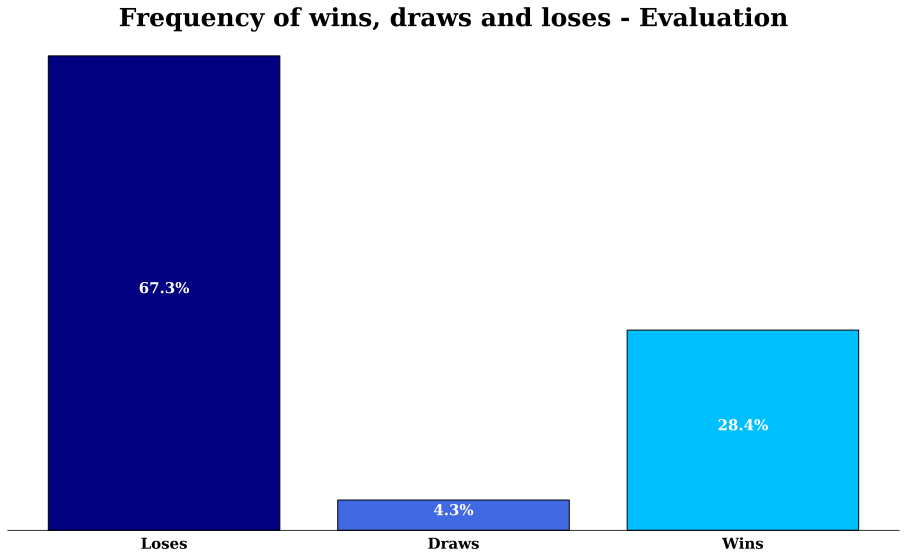

In [7]:
random_agent.plot_performance(
    rewards=evaluation_rewards,
    title="Frequency of wins, draws and loses - Evaluation",
    color=["navy", "royalblue", "deepskyblue"]
    )

# DQN

In [8]:
keras.backend.clear_session()
input_shape = [3] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(128, activation="elu", input_shape=input_shape),
    keras.layers.Dense(64, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

In [9]:
from importlib import reload
import src.agents
reload(src.agents)
from src.agents import DQNAgent

env.reset()
dqn_agent = DQNAgent(env=env,
                     num_states=3,
                     num_actions=2,
                     batch_size=200,
                     gamma=0.8)

In [10]:
train_rewards = dqn_agent.train(n_episodes=2000)

100%|██████████| 2000/2000 [03:24<00:00,  9.78it/s]


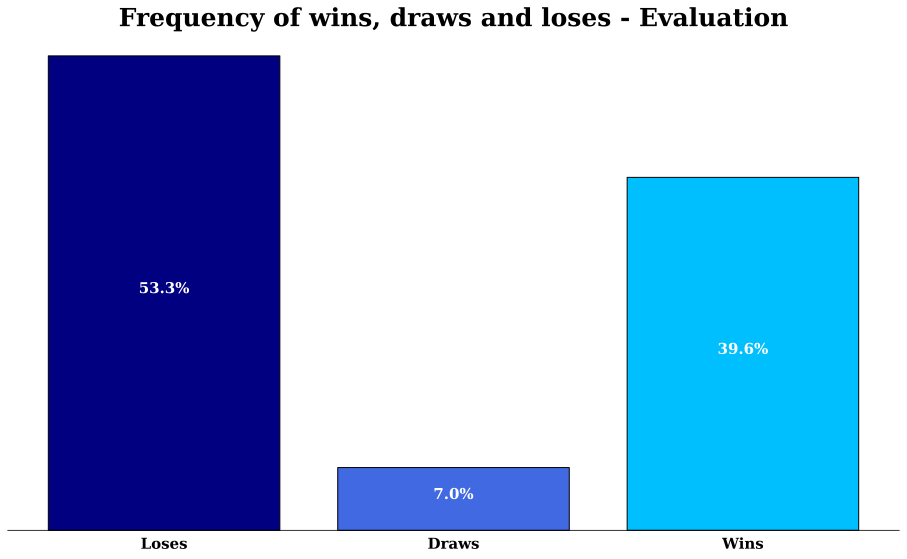

In [11]:
dqn_agent.plot_performance(
    rewards=train_rewards,
    title="Frequency of wins, draws and loses - Evaluation",
    color=["navy", "royalblue", "deepskyblue"]
    )

In [12]:
evaluation_rewards = dqn_agent.evaluate(n_episodes=100, save_images=True)

100%|██████████| 100/100 [00:08<00:00, 11.71it/s]


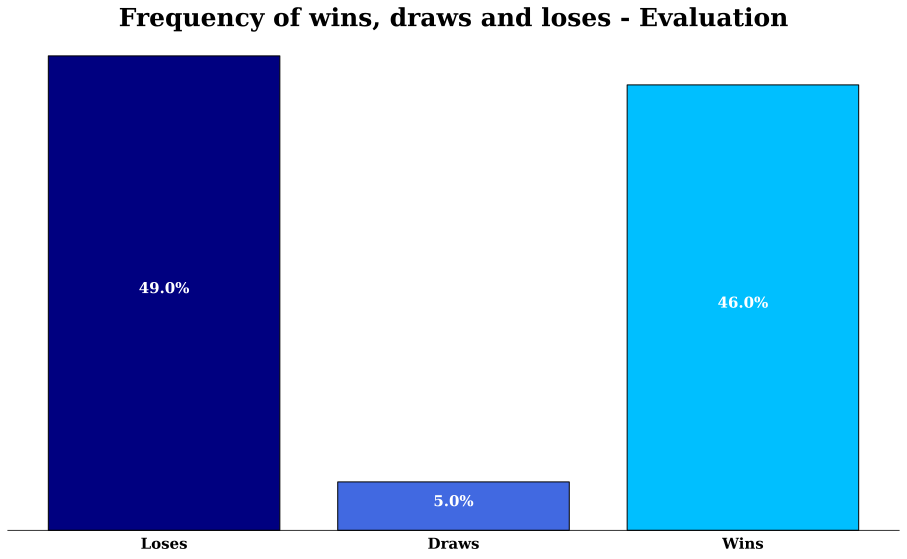

In [13]:
dqn_agent.plot_performance(
    rewards=evaluation_rewards,
    title="Frequency of wins, draws and loses - Evaluation",
    color=["navy", "royalblue", "deepskyblue"]
    )

In [14]:
# plot animation

animation = dqn_agent.plot_animation(interval=20)
dqn_agent.save_gif("../imgs/results_video.gif", animation, fps=5)